# Assignment 4

**Submission deadlines:**
- get at least 4 points by Tuesday, 11.05.2021
- remaining points: last lab session before or on Tuesday, 18.05.2021

**Points:** Aim to get 12 out of 15+ possible points


## Submission instructions
The class is held remotely. To submit your solutions please show the notebook over the video call. Make sure you know all the questions and answers, and that the notebook contains results (before presentation do `Runtime -> Restart and run all`)

We provide starter code, however, you are not required to use it as long as you properly solve the tasks.

As always, please submit corrections using GitHub's Pull Requests to https://github.com/janchorowski/dl_uwr.

# Problem 1: Word Embeddings [4p]

Many natural language processing tasks requrie continuous representations for words.
[Word embeddings](https://en.wikipedia.org/wiki/Word_embedding) are mappings from a discrete
space to real-valued vectors. Word embeddings might be trained with neural networks,
either as a by-product of other tasks (e.g., language modeling, neural machine translation),
or with networks designed specifically for the word embedding task.

Two problems associated with training neural word embeddings are related to the speed of training:
(a) large volume of data, on which the network has to be trained on, and (b) time required to compute
output probability distribution over large vocabularities.

One of the most popular architectures for training word embeddings is called Word2vec [[1]()], [[2]()]. It builds on the idea that semantics of a word can be defined through the contexts,
in which the word appears in the sentence.

Let $w_1, w_2,\ldots,w_N$ be an $N$-word sentence in a natural language.
We define a context of a word $w_l$ a list of $n$ preceeding and following words
$w_{l-n},\ldots,w_{l-1},w_{l+1},\dots,w_{l+n}$.

The underlying assumption is that similar words appear in similar contexts.
For instance, words *Poland* and *Monaco* are similar in a sense, that they are singular nouns
describing abstract concepts of existing, european countries.
We can convince ourselves by looking at exceprts from Wikipedia articles
on Poland and Monaco:

* Despite **Monaco's independence** and separate foreign policy
* aimed to preserve **Poland's independence** and the szlachta's

* **Monaco joined the** Council of Europe in 2004
* **Poland joined the** Schengen Area in 2007

* nearly one-fifth **of Poland's population** – half of them
* Christians comprise a total of 83.2% **of Monaco's population**.

### Tasks
You will use word vectors pre-computed on a large dataset.
1. **[1p]** It has been observed, that word embeddings allow to perform semantic arithmetic where, for instance

    **king** - **man** + **woman** ~= **queen**

    This *analogy* task is often used as a quality measure of word embeddings. Load word embeddings and compute
    their analogy score on a dataset of analogous pairs, expressed as an accuracy of accuracy of predicting a pair
    item (**queen** in the example above). Specifically, compare `FastText` and `Word2vec` word embeddings.
    
2. **[1p]** Word embedding capture approximate semantics. Under an assumption that words of similar semantics
    exist in different languages, a mapping $W: \mathbb{R}^{300}\mapsto\mathbb{R}^{300}$ might be constructed that
    translates word embeddings between languages. It has been shown that such ortonormal mappings allow to express
    approximate, bilingual dictionaries. In addition, non-linear mappings do not offer additional benefits.

    Given a simple English-Polish dictionary of word pairs (sourced from Wikitionary)
    find an orthonormal mapping $W$ between English and Polish `FastText`
    word embeddings using Procrustes analysis.

3. **[1p]** Word embeddings can often be nicely visualized.
    Make a 2-D `PCA` plot of word embeddings for countries and their capital cities
    for `FastText` or `Word2vec`. Connect each country with its capital city with a line segment.
    Can you see any regularities?
    
4. **[1p]** Plot 400 roughly most frequent words' embeddings (either `FastText` or `Word2vec`) in 2-D with `PCA`.
    Skip stop words, punctuations, artifact words, etc. You can be imprecise and use heuristics
    (e.g., select words than are at lest 3 charactes long).
    Can you see any regularities? Another method of making meaningful visualizations is `t-SNE`.
    
    Make another 2-D visualization, this time using `t-SNE`. Visualizations with `t-SNE` are obtained
    with gradient descent. Try to tweak optimization parameters to get lower optimization error,
    than the one with default parameters.
    Can you see any regularities this time?

## Starter code

In [1]:
# Please note that this code needs only to be run in a fresh runtime.
# However, it can be rerun afterwards too.

# Download word vectors
!pip install -q gdown httpimport
![ -e word2vec.tar.xz ] || gdown 'https://drive.google.com/uc?id=1v6D8IjYVFlonhQuN_J3PML5KSVQSpbED' -O word2vec.tar.xz
![ -d word2vec ] || tar Jxf word2vec.tar.xz

# Download conversation corpuses
![ -e  hackernews_pairs.txt ] || gdown 'https://drive.google.com/uc?id=10cp2maNp1suzc5BaFQwDJr2GTKXHQOz_' -O hackernews_pairs.txt
![ -e  reddit_pairs.txt ] || gdown 'https://drive.google.com/uc?id=1Uf0Xl9aqQVBBpOwhYTV7iWCwj95FDqtL' -O reddit_pairs.txt

Downloading...
From: https://drive.google.com/uc?id=1v6D8IjYVFlonhQuN_J3PML5KSVQSpbED
To: /home/maurycy/Desktop/university/MS2/NLP/week_4/word2vec.tar.xz
100%|████████████████████████████████████████| 395M/395M [01:48<00:00, 3.63MB/s]
Downloading...
From: https://drive.google.com/uc?id=10cp2maNp1suzc5BaFQwDJr2GTKXHQOz_
To: /home/maurycy/Desktop/university/MS2/NLP/week_4/hackernews_pairs.txt
100%|██████████████████████████████████████| 4.39M/4.39M [00:02<00:00, 1.49MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Uf0Xl9aqQVBBpOwhYTV7iWCwj95FDqtL
To: /home/maurycy/Desktop/university/MS2/NLP/week_4/reddit_pairs.txt
100%|██████████████████████████████████████| 3.89M/3.89M [00:02<00:00, 1.43MB/s]


In [2]:
# Huggingface Transformers implementation
!pip install -q tqdm boto3 requests regex sentencepiece sacremoses
!pip install -q transformers

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [23]:
import collections

import codecs

import numpy as np
from scipy.linalg import orthogonal_procrustes
from scipy.spatial import distance

import nltk
import sklearn
nltk.download('punkt')

import pprint
import gensim

import io
from tqdm.autonotebook import tqdm

import matplotlib.pyplot as plt
# import torch


import tabulate

[nltk_data] Downloading package punkt to /home/maurycy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Problem 1

## 1.1: Analogies

In [6]:
# Word embeddings assign a vector to each word. To use them we need three things:
# 1. the embeddings themselves
# 2. a dictionary from words to their embedding ids
# 3. an inverse dictionary

Embedding = collections.namedtuple(
    'Embedding',
    ['vec', 'word2idx', 'idx2word'])

In [7]:
def load_vecs_npy(base_path):
    """Load small embeddings in .npy format."""
    vec = np.load(base_path + '.npy')
    idx2word = [l.strip() for l in codecs.open(
                      base_path + '.txt', 'r', 'utf-8')]
    word2idx = {w:i for (i,w) in enumerate(idx2word)}
    return Embedding(vec, word2idx, idx2word)

In [8]:
# Load top 200k word embeddings: Word2vec and FastText
word2vec = load_vecs_npy('word2vec/word2vec_GoogleNews_200k')
ftext = load_vecs_npy('word2vec/fasttext_wikien_200k')

In [9]:
def load_analogies():
    '''Load tuples of analogies, e.g., (man, woman, king, queen)'''
    questions_path = 'word2vec/questions-words.txt'
    analogies = [l.strip().split() for l in open(questions_path, 'r') \
                 if not l.startswith(':')]
    return analogies

In [10]:
def eval_analogies(vecs, analogies):
    """
    Compute the accuracy on the analogy task.
    
    In the task, quadruples of words are given (q1, q2, r1, r2).
    The words q1 and q2 are bound by a relation. The words r1 and r2 
    are bound by the same relation. The task is to predict r2 knowing words
    q1, q2, and r1.
    
    Example:
    Quadruple [King, Queen, Man, Woman] yields the question
    King is to Queen as Man is to ????
    
    Args:
        word_vecs: Embeddings tupes
        analogies: list of quadruples: (q1, q2, r1, r2)
        
    Returns:
        percentage of correct answers
    """
    indexes = [[vecs.word2idx.get(w, None) for w in tupl] \
                for tupl in analogies]
    indexes = [tupl for tupl in indexes \
               if all([v is not None for v in tupl])]
    # indexes holds quadruples of ints giving the ids of words from our vocab.
    indexes = np.asarray(indexes)
    print('Got vocab for %d/%d pairs' % (indexes.shape[0], len(analogies)))
    
    # Extract the vectors for the query words
    q1 = vecs.vec[indexes[:, 0]]
    q2 = vecs.vec[indexes[:, 1]]
    r1 = vecs.vec[indexes[:, 2]]
    
    # Extractr the word IDs for the correct answers
    r2_inds = indexes[:, 3]

    #
    # TODO 
    #
    # Compute the approximate location of word r2 as r2 = r1 + (q2 - q1)
    # Find the word closest to this location using cosine distance.
    # Return it's id and compute the accurracy.
    #

    r2_pred = r1 + (q2-q1)
    
    
    # Normalize length and compute dot product between r2_pred and word_vecs
    # to get cosine distance
    r2_pred_norm = r2_pred / np.sqrt((r2_pred ** 2).sum(axis=1))[:, np.newaxis]
    vecs_norm = vecs.vec / np.sqrt((vecs.vec ** 2).sum(axis=1))[:, np.newaxis]  
    # Compute in chunks to save memory
    r2_pred_inds = np.concatenate([np.argmax(r2_pred_norm[i:i+1000].dot(vecs_norm.T), axis=1) \
                                   for i in range(0, r2_pred.shape[0], 1000)])
    return 100.0 * (r2_pred_inds == r2_inds).sum() / r2_inds.shape[0]

In [11]:
# Load analogy tuples, e.g., (man, woman, king, queen)
analogies = load_analogies()

# Some are uppercased geographical names (and FastTexts are lowercased)
analogies_lower = [[w.lower() for w in tupl] for tupl in analogies]

print(analogies[0])
print(analogies_lower[0])

['Athens', 'Greece', 'Baghdad', 'Iraq']
['athens', 'greece', 'baghdad', 'iraq']


In [12]:
# Keep in mind that the vocab is restricted to 200k most freq words
# (in the training corpus!)
print('FastText analogy task accuracy:')
print('-------------------------------')
# Fast-text was trained on lowercased text only
print(eval_analogies(ftext, analogies_lower), '% correct')

print('\nWord2vec analogy task accuracy:')
print('-------------------------------')
# Word2vec has case information
print(eval_analogies(word2vec, analogies), '% correct')

FastText analogy task accuracy:
-------------------------------
Got vocab for 19420/19544 pairs
16.374871266735326 % correct

Word2vec analogy task accuracy:
-------------------------------
Got vocab for 18783/19544 pairs
20.859287653729435 % correct


## 1.2: translation through alignment of vector spaces

In [13]:
# We're need Polish embeddings
ftext_pl = load_vecs_npy('word2vec/fasttext_wikipl_200k')

# Load a simple wikitionary-based dict of word pairs
en_pl = [l.strip().split('\t') for l in codecs.open(
    'word2vec/word2vec_en_pl', 'r', 'utf-8') if not '<UNK>' in l]
en_pl = {t[0]:t[1] for t in en_pl if len(t) == 2}

# Keep those, for which we have embeddings
en_pl = {en:pl for (en,pl) in en_pl.items() \
         if en in ftext.word2idx and pl in ftext_pl.word2idx}
print('Dictionary size:', len(en_pl))
print('good --', en_pl['good'])

Dictionary size: 750
good -- dobro


In [14]:
# Select word embeddings for dictionary words
en_words = sorted(en_pl.keys())
V_en = ftext.vec[[ftext.word2idx[w] for w in en_words]]
V_pl = ftext_pl.vec[[ftext_pl.word2idx[en_pl[w]] for w in en_words]]
print(V_en.shape, V_pl.shape)

(750, 300) (750, 300)


In [15]:
# Find an orthogonal transformation from V_en to V_pl.
# which minimizes square reconstruction error
W = orthogonal_procrustes(V_en, V_pl)[0]

In [19]:
def translate(W, v, vecs2):
    #
    # TODO
    #
    # Transform source word vector v using W getting a location in target space.
    # Find the closest word in target space using the cosine distance.
    #
    vecs_norm = vecs2.vec / np.sqrt((vecs2.vec ** 2).sum(axis=1))[:, np.newaxis]
    v_t = v@W
    v_t = v_t / np.sqrt((v_t**2).sum())
    idx = np.argmax(v_t@vecs_norm.T)
    
    return vecs2.idx2word[idx]

# Select random, fairly frequent words not from the dictionary
tr_words = [i for i in np.random.randint(1000, 2000, 100) \
            if ftext.idx2word[i] not in en_pl]
tr_words = tr_words[:20]

rows = [[ftext.idx2word[i], translate(W, ftext.vec[i], ftext_pl)] \
         for i in tr_words] 
print(tabulate.tabulate(rows))

------------  -------------
box           glitter
scientific    badania
fine          elegancko
sri           ichiran
religious     religijny
urban         urbanistyczny
reasons       powód
isn           powiedziałbym
en            ziółka
ed            philologie
stack         tcp/ip
races         wyścig
referred      określany
specifically  przykład
ended         koniec
suggested     sugerował
mixed         pozytywny
en            ziółka
scores        wynik
scott         sebastian
------------  -------------


## 1.3: PCA

In [20]:
capitals = [l.strip().split('\t') for l in codecs.open('word2vec/countries_capitals', 'r', 'utf-8')]
capitals = {country:capital for (country,capital) in capitals}

# Select those present in Word2vec vocab
capitals = {k:v for (k,v) in capitals.items() \
            if k in word2vec.word2idx and v in word2vec.word2idx}

# Flatten the array to have a list of [country, capital, country, capital, ...]
geo = [e for pair in capitals.items() for e in pair]
print(len(geo) // 2, 'pairs', geo[:6])

131 pairs ['Afghanistan', 'Kabul', 'Albania', 'Tirana', 'Algeria', 'Algiers']


In [21]:
geo_inds = [word2vec.word2idx[w] for w in geo]
geo_vecs = word2vec.vec[geo_inds]
print(geo_vecs.shape)

(262, 300)


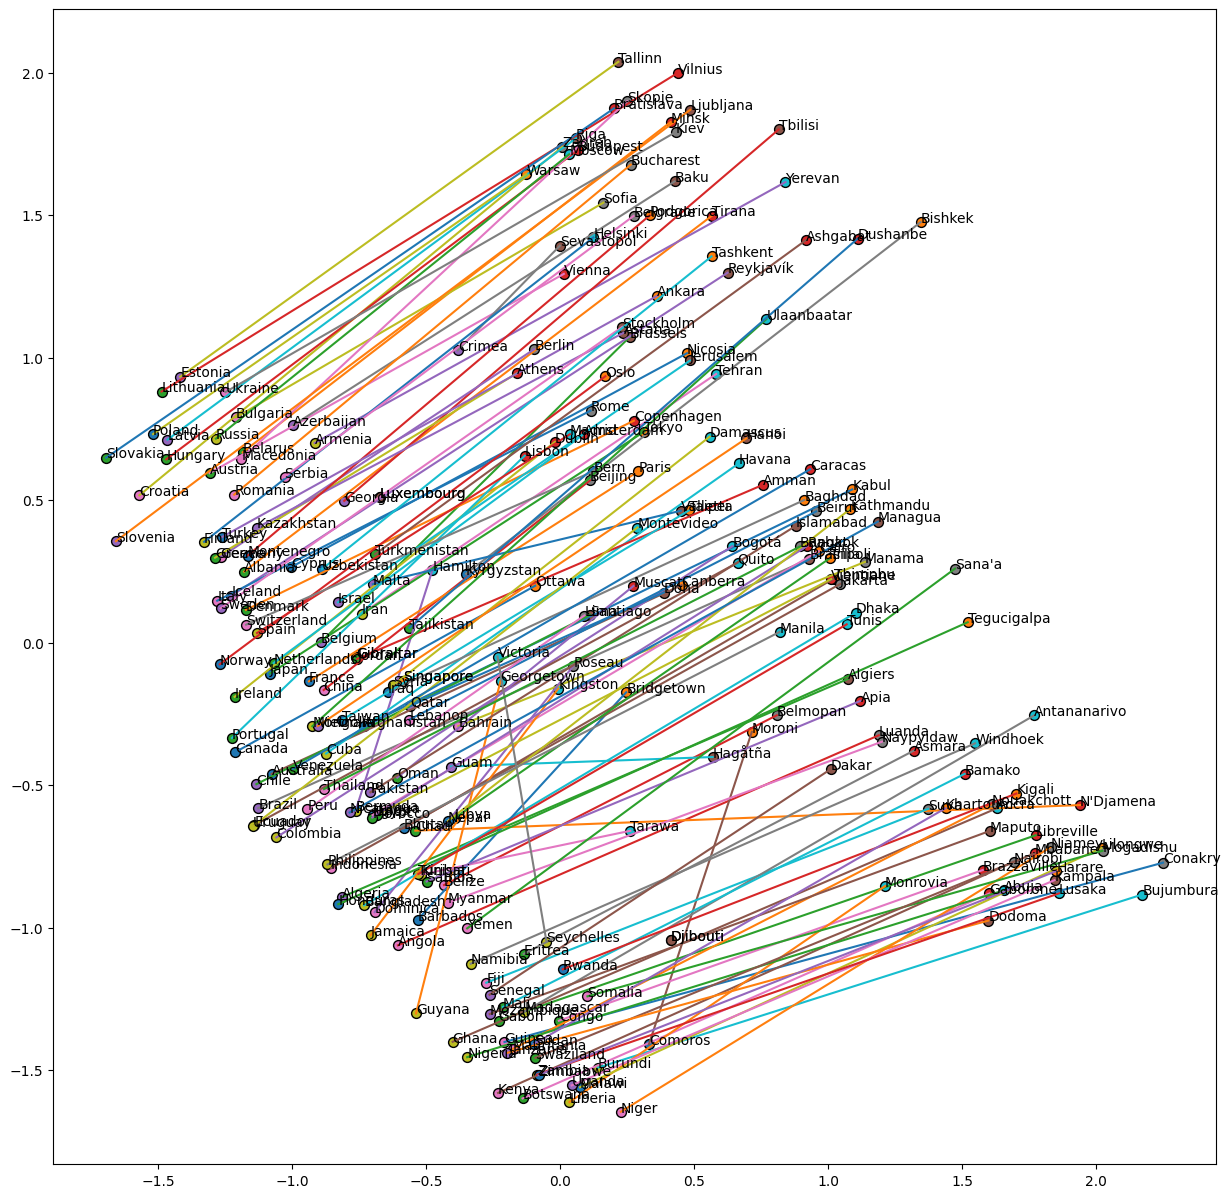

In [24]:
from sklearn.decomposition import PCA

#
# TODO
# use PCA from sklearn.decomposition to project the countries and capitals into 2D.
# draw lines connecting each country with its capital
#
# Hint:
# - the function "annotate" can be used to put text onto the plot
#
pca = PCA(n_components=2)
geo_vecs2D = pca.fit_transform(geo_vecs)
plt.figure(figsize=(15,15))
for i,t in enumerate(geo_vecs2D):
  x, y = t
  plt.scatter(x, y, edgecolors='black', s=50)
  plt.annotate(geo[i], xy=(x,y))
  if geo[i] in capitals:
    capital = capitals[geo[i]]
    idx = geo.index(capital)
    d = geo_vecs2D[idx]
    plt.plot((x, d[0]), (y, d[1]))
plt.show()  


## 1.4: PCA vs t-SNE on frequent words

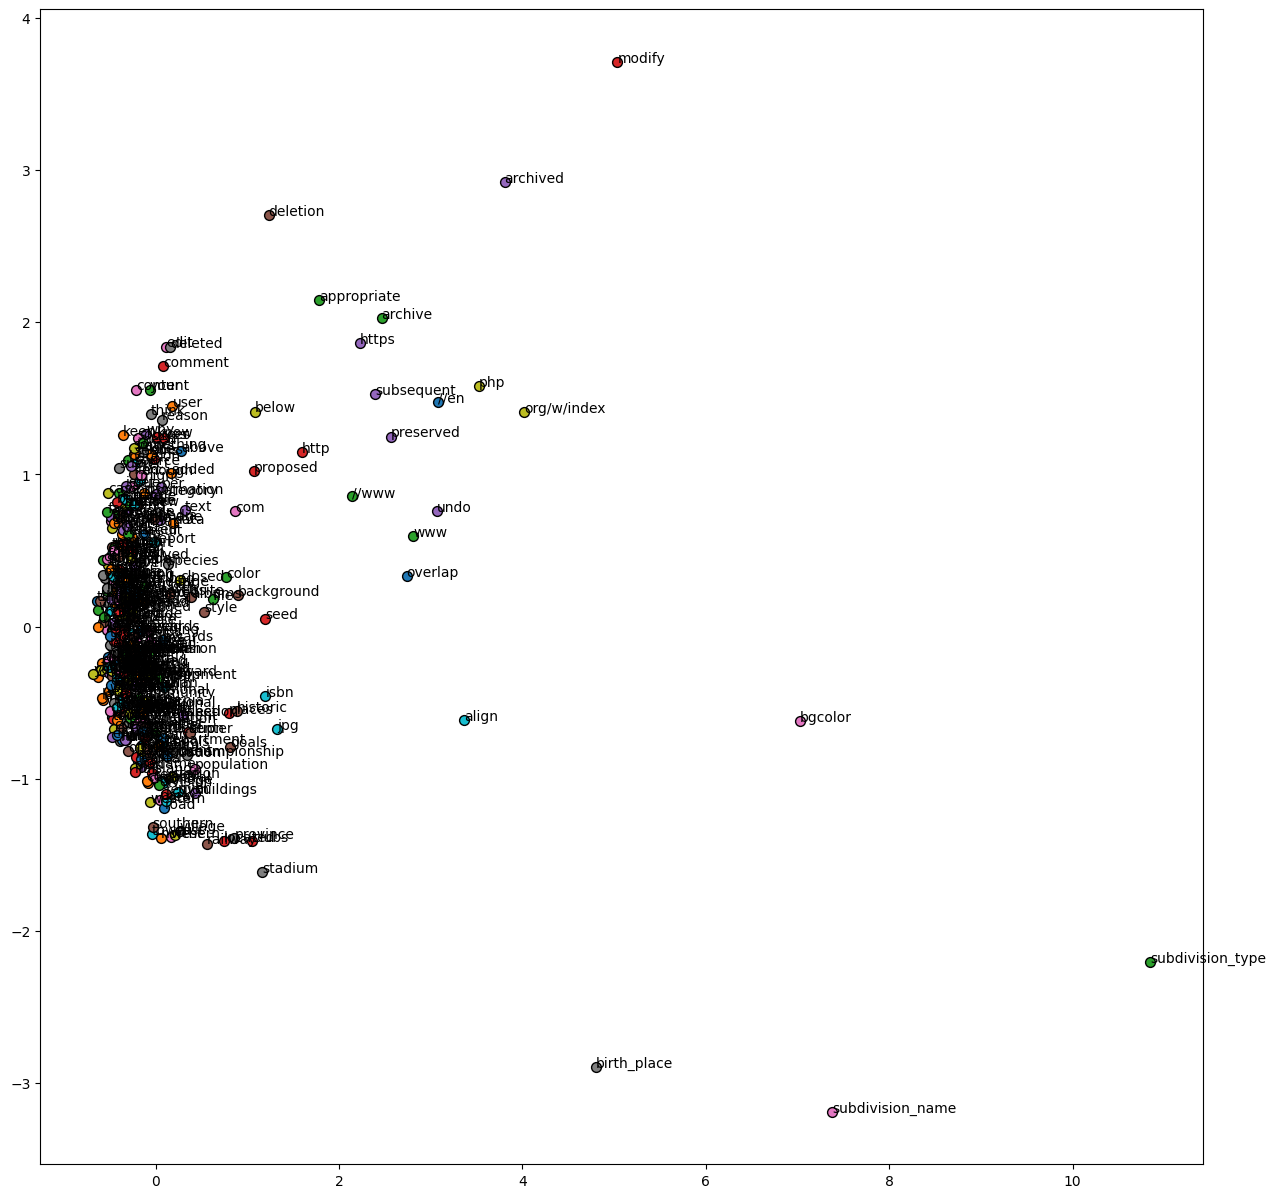

In [25]:
# Select words starting from the 200th to ommit stop words,
# which have at least 3 chars
top_words = [w for (i,w) in enumerate(ftext.idx2word) \
             if i > 200 and len(w) >= 3][:400]
top_inds = [ftext.word2idx[w] for w in top_words]


word_vecs = ftext.vec[top_inds]

pca = PCA(n_components=2)
word_vecs2D = pca.fit_transform(word_vecs)

plt.figure(figsize=(15,15))

for i,t in enumerate(word_vecs2D):
  x, y = t
  plt.scatter(x, y, edgecolors='black', s=50)
  plt.annotate(top_words[i], xy=(x,y))
plt.show()  

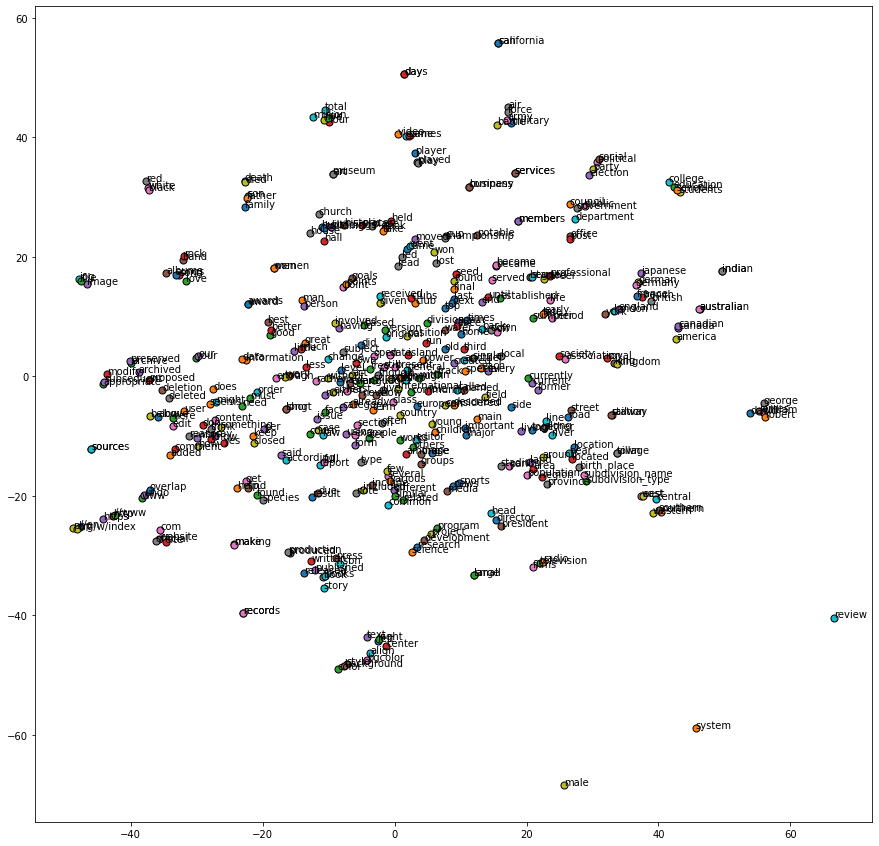

In [20]:
from sklearn.manifold import TSNE

#
# TODO: make a 2D t-SNE projection of the selected words.
# Things will cluster much nicer
#

tsne = TSNE(n_components=2, perplexity=5, learning_rate=10)
word_vecs2D = tsne.fit_transform(word_vecs)

plt.figure(figsize=(15,15))

for i,t in enumerate(word_vecs2D):
  x, y = t
  plt.scatter(x, y, edgecolors='black', s=50)
  plt.annotate(top_words[i], xy=(x,y))
plt.show()  

Cluster 1 / 3


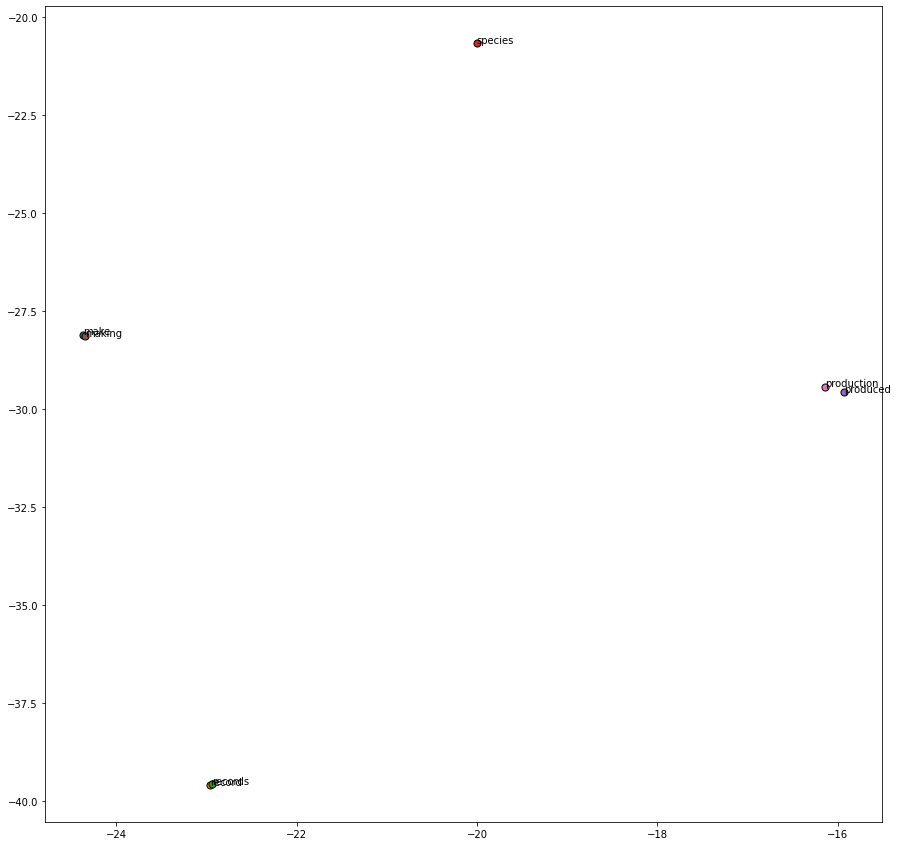

Cluster 2 / 3


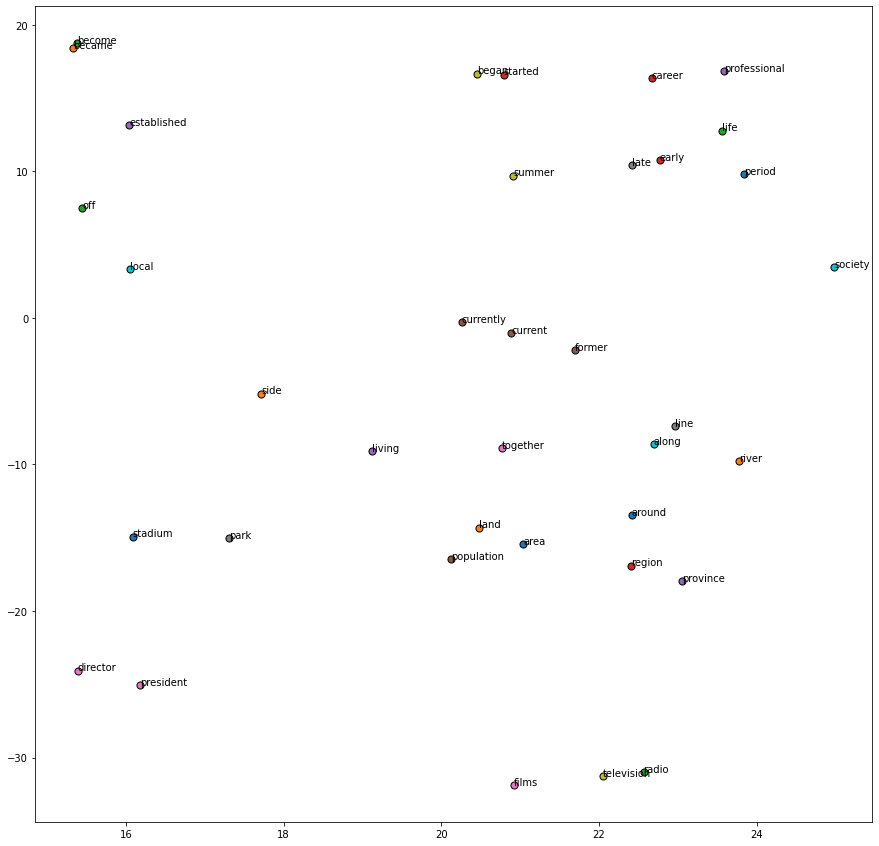

Cluster 3 / 3


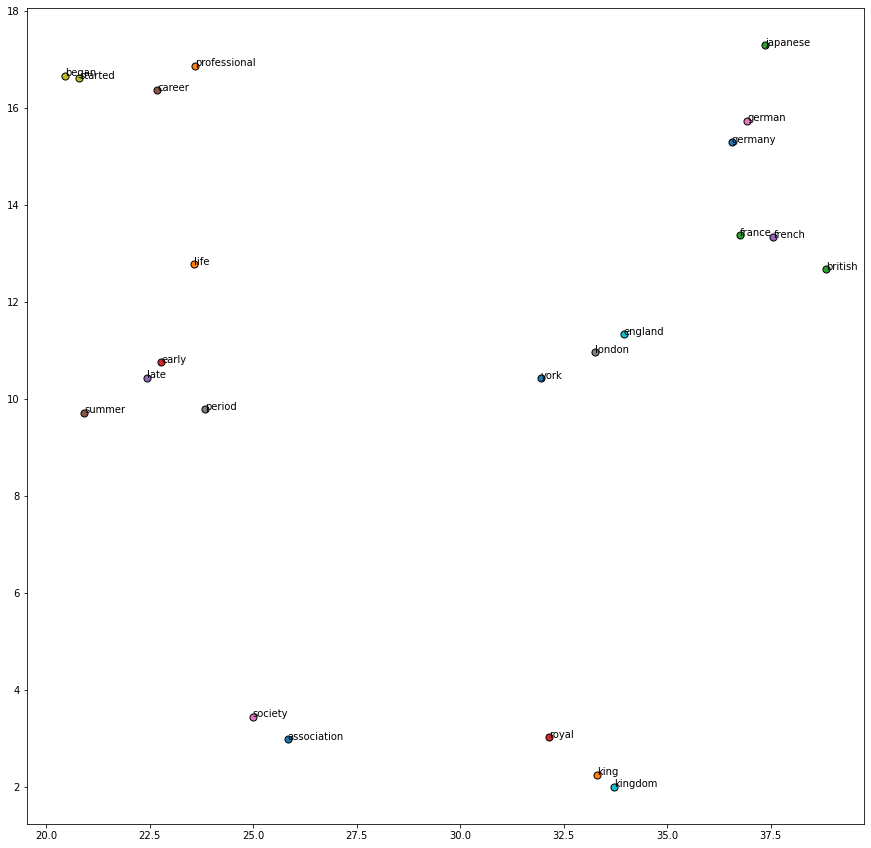

In [21]:
# TODO: zomm in on 3 meaningful clusters
Xls = [-25, 15, 20]
Xrs = [-15, 25, 40]

Yls = [-40, -40, 0]
Yrs = [-20, 20, 20]

for k in range(len(Xls)):
  print(f'Cluster {k + 1} / {len(Xls)}')
  plt.figure(figsize=(15, 15))
  for i, t in enumerate(word_vecs2D):
    x, y = t
    if Xls[k] <= x <= Xrs[k] and Yls[k] <= y <= Yrs[k]:
      plt.scatter(x, y, edgecolors='black', s=50)
      plt.annotate(top_words[i], xy=(x, y))

  plt.show()